#Before to start
Manually copy the dataset file `'train_128x128.npz'` in a directory in your Google Drive and move to that directory

Import the needed python modules.
Add here all the python module you need to complete the homework.

In [3]:
import numpy as np
import matplotlib.pyplot as plt

#Connect to Google Drive
Mount Google Drive into Colaboratory,
then move the work directory to the Google Drive directory where you copied the dataset file.

In [4]:
from google.colab import drive
drive.mount('/content/drive')

import os
os.chdir('/content/drive/My Drive/Colab Notebooks/Homework')  # edit this path to match that of your Google Drive directory

Mounted at /content/drive


#Load the training set and print information
The dataset spatial resolution is `128x128` and it fits in the RAM of the Colaboratory virtual machine. Avoid duplicating the dataset in memory multiple times. If you have memory problems, subsample all the images along rows and columns using the `numpy array slicing`.

In this cell we also define the `class_names` tuple to associate class indexes with the corresponding label (either `'cat'` or `'dog'`).

In [5]:
train = np.load('trainANDvalidation.npz', allow_pickle=True)

X_train = train['X_train']
y_train = train['y_train']
X_val = train['X_val']
y_val = train['y_val']

training_samples, img_rows, img_cols, img_channels = X_train.shape

print('\nX_train:\n- shape', X_train.shape,'\n- type:', X_train.dtype,'\n- min value:', X_train.min(),'\n- max value:', X_train.max())
print('\ny_train:\n- shape', y_train.shape,'\n- type:', y_train.dtype,'\n- min value:', y_train.min(),'\n- max value:', y_train.max())
print('\nX_val:\n- shape', X_val.shape,'\n- type:', X_val.dtype,'\n- min value:', X_val.min(),'\n- max value:', X_val.max())
print('\ny_val:\n- shape', y_val.shape,'\n- type:', y_val.dtype,'\n- min value:', y_val.min(),'\n- max value:', y_val.max())

class_names = ('cat', 'dog')
num_classes = 2


X_train:
- shape (17000, 128, 128, 3) 
- type: uint8 
- min value: 0 
- max value: 255

y_train:
- shape (17000,) 
- type: uint8 
- min value: 0 
- max value: 1

X_val:
- shape (3000, 128, 128, 3) 
- type: uint8 
- min value: 0 
- max value: 255

y_val:
- shape (3000,) 
- type: uint8 
- min value: 0 
- max value: 1


# Sample visualization

In [6]:
index = 0

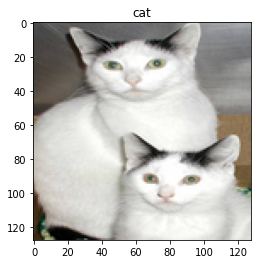

In [7]:
plt.imshow(X_train[index])
plt.title(class_names[y_train[index]])
index += 1

#Evaluation procedure

##Import

In [8]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from keras.models import load_model
import cv2

##Functions

In [9]:
def one_hot(a, n):
  e = np.eye(n) # Identity matrix n x n
  result=e[a.astype(np.uint8)]
  return result

In [10]:
def print_prediction_result(prediction, target):
  '''
  prediction: 1x10 (class number) numpy array of prediction of one sample
  targed: scalar (int) representing the true class of the sample
  '''
  prediction = prediction.squeeze()       # remove trailing dimensions
  predicted = prediction.argmax()         # take the predicted class index
  predicted_name = class_names[predicted]     # take the predicted class name using the classes global variable
  predicted_conf = prediction[predicted]  # take the predicted confidence or score

  target_name = class_names[target]           # take the true class name
  target_conf = prediction[target]        # take the predicted confidence of the true class

  # print results
  if predicted == target:
    print('Correctly predicted class {} with confidence\t{:.2f}'.format(predicted_name, predicted_conf))
  else:
    print('Error!\n- predicted class\t{}\twith confidence\t{:.2f}\n- correct   class\t{}\thas confidence\t{:.2f}'.format(predicted_name, predicted_conf, target_name, target_conf))


In [11]:
def plot_confusion_matrix(y, pred, title):
  ConfusionMatrixDisplay.from_predictions(y, pred,
                                          display_labels=np.array(class_names),
                                          normalize='true',
                                          values_format='.2f',
                                          xticks_rotation=45
                                          )
  # Visualization commands
  plt.gcf().set_size_inches(10, 10)         # bigger image
  plt.gca().get_images()[0].set_clim(0, 1)  # same color map in the range [0, 1]
  plt.title(title)                          # print the title

##Data normalization

In [12]:
X_train = X_train.astype('float32') / 255
X_val = X_val.astype('float32') / 255

##Model loading

In [13]:
CNN = load_model('model')

##Check prediction on one sample

In [14]:
y_val_pred_CNN_prob = CNN.predict(X_val)
y_val_pred_CNN = y_val_pred_CNN_prob.argmax(1)

Target dog

CNN prediction:
Correctly predicted class dog with confidence	1.00


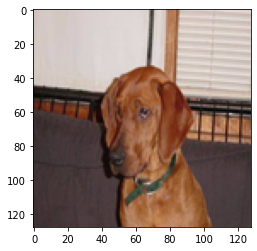

In [15]:
index += 1
target = y_val[index:index+1].item()
print('Target', class_names[target])
plt.imshow(X_val[index])

print('\nCNN prediction:')
print_prediction_result(y_val_pred_CNN_prob[index], target)

##Validation set performance computation

In [16]:
y_val_1h = one_hot(y_val, num_classes)

###CNN evaluation

In [17]:
print("CNN evaluation")
test_loss, test_acc = CNN.evaluate(X_val, y_val_1h)

CNN evaluation
94/94 [==============================] - 4s 41ms/step - loss: 0.2428 - accuracy: 0.9427


###Confusion matrix

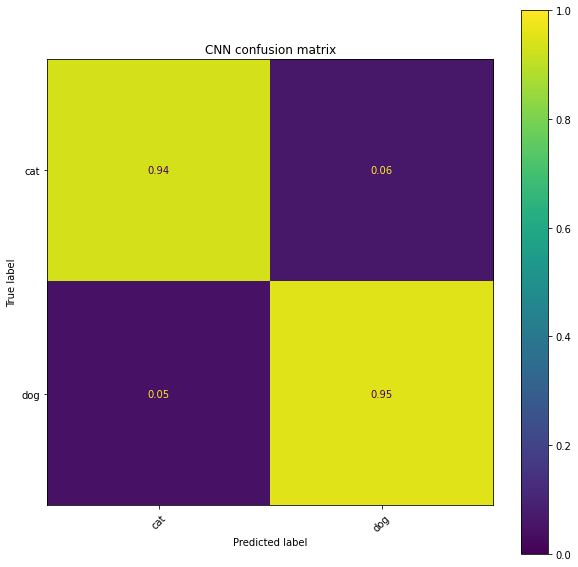

In [18]:
plot_confusion_matrix(y_val, y_val_pred_CNN, 'CNN confusion matrix')

##Tensorboard screenshot

#Our test set procedure

##Download

In [19]:
!wget -nc https://github.com/soyesa-19/cats_vs_dogs/raw/master/cats_vs_dogs_test_images.npz
!wget -nc https://github.com/soyesa-19/cats_vs_dogs/raw/master/cats_vs_dogs_test_labels.npz

File ‘cats_vs_dogs_test_images.npz’ already there; not retrieving.

File ‘cats_vs_dogs_test_labels.npz’ already there; not retrieving.



##Pre-processing

In [20]:
test = np.load('cats_vs_dogs_test_images.npz', allow_pickle=True)
test_labels = np.load('cats_vs_dogs_test_labels.npz', allow_pickle=True)

X_test_raw = test['arr_0']
y_test = test_labels['arr_0']

X_test = np.empty(shape=(X_test_raw.shape[0], 128, 128, 3), dtype=np.uint8)

for i, img in enumerate(X_test_raw):
    X_test[i] = cv2.resize(img, dsize=(128, 128))

training_samples, img_rows, img_cols, img_channels = X_test.shape

print('X_test_mod:\n- shape', X_test.shape, '\n- type:', X_test.dtype,
      '\n- min value:', X_test.min(), '\n- max value:', X_test.max())
print('\ny_test:\n- shape', y_test.shape, '\n- type:', y_test.dtype,
      '\n- min value:', y_test.min(), '\n- max value:', y_test.max())

count_arr_test = np.bincount(y_test)

print("\nIn the test set there are "+str(count_arr_test[0])+" cats and "+str(count_arr_test[1])+" dog")

X_test = X_test.astype('float32') / 255

class_names = ('cat', 'dog')
num_classes = 2


X_test_mod:
- shape (1000, 128, 128, 3) 
- type: uint8 
- min value: 0 
- max value: 255

y_test:
- shape (1000,) 
- type: int32 
- min value: 0 
- max value: 1

In the test set there are 500 cats and 500 dog


##Prediction

In [21]:
y_test_pred_CNN_prob = CNN.predict(X_test)
y_test_pred_CNN = y_test_pred_CNN_prob.argmax(1)

In [22]:
y_test_1h = one_hot(y_test, num_classes)

##Test set performance computation

###CNN evaluation

In [23]:
print("CNN evaluation")
test_loss, test_acc = CNN.evaluate(X_test, y_test_1h)

CNN evaluation
32/32 [==============================] - 1s 41ms/step - loss: 0.2167 - accuracy: 0.9230


###Confusion matrix

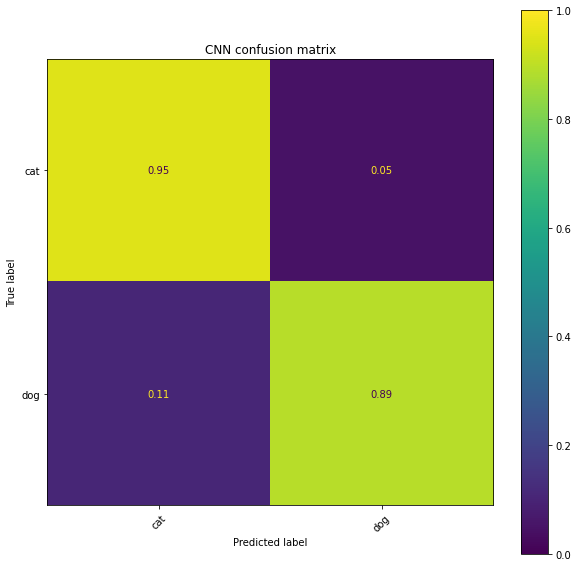

In [24]:
plot_confusion_matrix(y_test, y_test_pred_CNN, 'CNN confusion matrix')